In [0]:
print("Hello world")

Hello world


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
ls

 BOW.ipynb                           VGG_Bottleneck_Train_Labels.pkl
 bow_vgg.ipynb                       VGG-FineTune-DA.h5
 codebook.pkl                        VGG-FineTune-DataAugementation
 descriptors_test.npy                VGG-FineTune.h5
 descriptors_train.npy               VGG-FineTuning
 Lab12.ipynb                         vgg-fullyconnected.h5
 NWPU-RESISC12/                      VGG_FullyConnected.ipynb
 NWPUvip.zip                         vgg_places_30_epochs.h5
 __pycache__/                        vgg_places_and_16.ipynb
 res-classifier.h5                   VGG_Places_Bottleneck_Test_Features.pkl
 RES_FineTune.ipynb                  VGG_Places_Bottleneck_Test_Labels.pkl
 ResNetFineTune.h5                   VGG_Places_Bottleneck_Train_Features.pkl
 ResNetFineTune_weights.h5           VGG_Places_Bottleneck_Train_Labels.pkl
 restnet.ipynb                       vgg_places_data_aug.h5
 vgg16_places_365.py                 vgg_places_data_aug.ipynb
 vgg16_places_history.png     

In [0]:
ls drive/My\ Drive/vip2

ls: cannot access 'drive/My Drive/vip2': No such file or directory


In [0]:
pwd

'/content'

In [0]:
cd /content

/content


In [0]:
import time
t1 = time.time()
!unzip -q "drive/My Drive/vip2/NWPUvip.zip"
t2 = time.time()
print(t2-t1)

6.369332790374756


In [0]:
!cd drive
!cd
!ls

drive  NWPU-RESISC12  sample_data


In [0]:
train_dir = 'NWPU-RESISC12/train'
test_dir  = 'NWPU-RESISC12/test' 
image_size = 224
nTrain = 6600
nTest = 1800

In [0]:
pwd

'/content'

In [0]:
cd drive/My\ Drive/vip2

/content/drive/My Drive/vip2


In [0]:
from vgg16_places_365 import VGG16_Places365
vgg16_places = VGG16_Places365(weights='places', include_top=False, input_shape=(224, 224, 3))

Using TensorFlow backend.






58916864/58909656 [==============================] - 2s 0us/step




In [0]:
vgg16_places.summary()

NameError: ignored

In [0]:
pwd

'/content/drive/My Drive/vip2'

In [0]:
cd /content

/content


In [0]:
ls

drive/  sample_data/  VGG_Places_Bottleneck_Train_Features.pkl


In [0]:
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, load_img
import numpy as np

# Train :: Extract Features
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

train_features = np.zeros(shape=(nTrain, 7, 7, 512))
train_labels = np.zeros(shape=(nTrain,12))

print('data generator')
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)


data generator
Found 6600 images belonging to 12 classes.


In [0]:

print('predicting...')
i = 0
for inputs_batch, labels_batch in train_generator:
    features_batch = vgg16_places.predict(inputs_batch)
    train_features[i*batch_size:(i+1)*batch_size]=features_batch
    train_labels[i*batch_size:(i+1)*batch_size]=labels_batch
    i+=1
    print(i,end='')
    if i*batch_size >= nTrain:
        break

train_features = np.reshape(train_features, (nTrain, 7 * 7 * 512))
print('\nDONE')

In [0]:
np.save("filename",train_feature)


In [0]:
# Save
import pickle
with open('drive/My Drive/vip2/VGG_Places_Bottleneck_Train_Features.pkl','wb') as handle:
    pickle.dump(train_features, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('drive/My Drive/vip2/VGG_Places_Bottleneck_Train_Labels.pkl','wb') as handle:
    pickle.dump(train_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
# Load
import pickle
with open('drive/My Drive/vip2/VGG_Places_Bottleneck_Train_Features.pkl','rb') as handle:
    train_features = pickle.load(handle)
with open('drive/My Drive/vip2/VGG_Places_Bottleneck_Train_Labels.pkl','rb') as handle:
    train_labels = pickle.load(handle)

In [0]:
test_features = np.zeros(shape=(nTest, 7, 7, 512))
test_labels = np.zeros(shape=(nTest,12))

print('Data generator')
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)


Data generator
Found 1800 images belonging to 12 classes.


In [0]:

print('save features')
i = 0
for inputs_batch, labels_batch in test_generator:
    features_batch = vgg16_places.predict(inputs_batch)
    test_features[i * batch_size : (i + 1) * batch_size] = features_batch
    test_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    print(i,end=' ')
    if i * batch_size >= nTest:
        break

test_features = np.reshape(test_features, (nTest, 7 * 7 * 512))

In [0]:
ls

drive/  NWPU-RESISC12/  sample_data/


In [0]:
from keras import models
from keras import layers
from keras import optimizers

# Freeze all the layers
for layer in vgg16_places.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg16_places.layers:
    print(layer, layer.trainable)

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg16_places)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation='softmax'))

<keras.engine.input_layer.InputLayer object at 0x7f1735da4f98> False
<keras.layers.convolutional.Conv2D object at 0x7f16ff631518> False
<keras.layers.convolutional.Conv2D object at 0x7f16ff631860> False
<keras.layers.pooling.MaxPooling2D object at 0x7f16fedf80b8> False
<keras.layers.convolutional.Conv2D object at 0x7f16fede1710> False
<keras.layers.convolutional.Conv2D object at 0x7f16feda9be0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f16fedbca20> False
<keras.layers.convolutional.Conv2D object at 0x7f16fedbc0f0> False
<keras.layers.convolutional.Conv2D object at 0x7f16fed81898> False
<keras.layers.convolutional.Conv2D object at 0x7f16fed15c50> False
<keras.layers.pooling.MaxPooling2D object at 0x7f16fed42c18> False
<keras.layers.convolutional.Conv2D object at 0x7f16fed42828> False
<keras.layers.convolutional.Conv2D object at 0x7f16feceefd0> False
<keras.layers.convolutional.Conv2D object at 0x7f16fec9abe0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f16fecc6630>

In [0]:
cd /content

/content


In [0]:
ls

drive/  NWPU-RESISC12/  sample_data/


In [0]:
from keras.optimizers import Adam
validation_generator = test_generator
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['acc'])

# Train the Model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)


Epoch 1/30
330/330 [==============================] - 120s 364ms/step - loss: 1.3227 - acc: 0.6362 - val_loss: 0.9189 - val_acc: 0.7722
Epoch 2/30
330/330 [==============================] - 116s 352ms/step - loss: 0.7408 - acc: 0.8285 - val_loss: 0.6942 - val_acc: 0.8522
Epoch 3/30
330/330 [==============================] - 116s 353ms/step - loss: 0.5529 - acc: 0.8817 - val_loss: 0.6708 - val_acc: 0.8622
Epoch 4/30
330/330 [==============================] - 116s 353ms/step - loss: 0.4569 - acc: 0.9218 - val_loss: 0.6609 - val_acc: 0.8650
Epoch 5/30
330/330 [==============================] - 116s 353ms/step - loss: 0.3912 - acc: 0.9405 - val_loss: 0.6633 - val_acc: 0.8722
Epoch 6/30
330/330 [==============================] - 117s 353ms/step - loss: 0.3457 - acc: 0.9527 - val_loss: 0.6563 - val_acc: 0.8717
Epoch 7/30
330/330 [==============================] - 117s 353ms/step - loss: 0.3206 - acc: 0.9621 - val_loss: 0.8115 - val_acc: 0.8444
Epoch 8/30
330/330 [============================

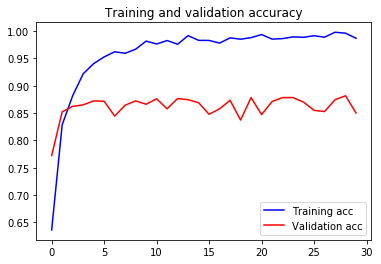

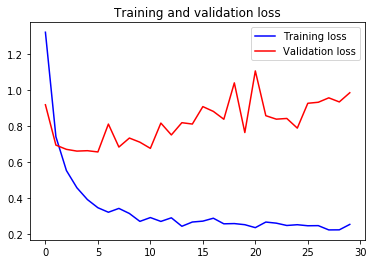

In [0]:
import matplotlib.pyplot as plt
# Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
cd  /content/drive/My Drive/Colab Notebooks/vip2/

/content/drive/My Drive/Colab Notebooks/vip2


In [0]:
cd drive/My\ Drive/vip2

[Errno 2] No such file or directory: 'drive/My Drive/vip2'
/content


In [0]:
model.save("vgg_places_30_epochs.h5")

In [0]:
from keras.models import load_model

model = load_model("vgg_places_30_epochs.h5")

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16-places365 (Model)      (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                12300     
Total params: 40,418,124
Trainable params: 32,782,860
Non-trainable params: 7,635,264
_________________________________________________________________


In [0]:
model.pop()
model.pop()
model.pop()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16-places365 (Model)      (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
Total params: 40,418,124
Trainable params: 32,782,860
Non-trainable params: 7,635,264
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
cd /content

/content


In [0]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

train_features = np.zeros(shape=(nTrain, 7, 7, 512))
train_labels = np.zeros(shape=(nTrain,12))

print('data generator')
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

print('predicting...')
i = 0
for inputs_batch, labels_batch in train_generator:
    features_batch = model.predict(inputs_batch)
    #print(features_batch.shape)
    features_batch = features_batch.reshape(batch_size, 7, 7, 512)
    train_features[i*batch_size:(i+1)*batch_size]=features_batch
    train_labels[i*batch_size:(i+1)*batch_size]=labels_batch
    i+=1
    print(i,end='')
    if i*batch_size >= nTrain:
        break
print('\nreshape')
train_features = np.reshape(train_features, (nTrain, 7 * 7 * 512))

NameError: ignored

In [0]:
test_features = np.zeros(shape=(nTest, 7, 7, 512))
test_labels = np.zeros(shape=(nTest,12))

print('Data generator')
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

print('predicting')
i = 0
for inputs_batch, labels_batch in test_generator:
    features_batch = model.predict(inputs_batch)
    features_batch = features_batch.reshape(batch_size, 7, 7, 512)
    test_features[i * batch_size : (i + 1) * batch_size] = features_batch
    test_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    print(i,end=' ')
    if i * batch_size >= nTest:
        break
print('reshape')
test_features = np.reshape(test_features, (nTest, 7 * 7 * 512))

NameError: ignored

In [0]:
cd drive/My\ Drive/vip2

/content/drive/My Drive/vip2


In [0]:
import pickle
with open('VGG_Places_Bottleneck_Train_Features.pkl','wb') as handle:
    pickle.dump(train_features, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('VGG_Places_Bottleneck_Train_Labels.pkl','wb') as handle:
    pickle.dump(train_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)



NameError: ignored

In [0]:

with open('VGG_Places_Bottleneck_Test_Features.pkl','wb') as handle:
    pickle.dump(test_features, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('VGG_Places_Bottleneck_Test_Labels.pkl','wb') as handle:
    pickle.dump(test_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
train_features.shape

(6600, 25088)

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16-places365 (Model)      (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                12300     
Total params: 40,418,124
Trainable params: 32,782,860
Non-trainable params: 7,635,264
_________________________________________________________________


In [0]:
pwd

'/content/drive/My Drive/Colab Notebooks/vip2'

In [0]:
# Load
import pickle
with open('VGG_Places_Bottleneck_Test_Features.pkl','rb') as handle:
    test_features = pickle.load(handle)
with open('VGG_Places_Bottleneck_Test_Labels.pkl','rb') as handle:
    test_labels = pickle.load(handle)

In [0]:
test_features.shape

(1800, 25088)

In [0]:
test_labels.shape

(1800, 12)

In [0]:
test_features = test_features.reshape(nTest,7,7,512)

In [0]:
model = load_model("")

In [0]:
y_true = test_generator.classes

In [0]:
predictions = model.predict_generator(test_generator)
predicted_classes = np.argmax(predictions,axis=1)
#test_labels = np.argmax(test_labels,axis=1)

In [0]:
scores(y_true,predicted_classes)

Accuracy:  0.85
Precision: 0.8593480809063424
Recall:    0.85
F1:        0.850256440571119
Confusion matrix:
[[146   0   2   1   0   0   0   0   0   0   1   0]
 [  0 148   0   0   0   1   0   0   0   1   0   0]
 [  1   0 135   0   1   0   0   1  11   0   0   1]
 [  1   1   0 125   0   1   0   2   3   3  12   2]
 [  0   0   0   0 141   0   0   1   1   1   5   1]
 [  0  27   0   2   0 118   0   0   1   2   0   0]
 [  7   0   1   0   0   0 136   0   0   0   6   0]
 [  3   0   0   0   0   0   4 121   2   0  16   4]
 [  4   0   6   0   0   0   0   1 125   0  11   3]
 [  2  11   1   0   2   7   2   1   2 115   5   2]
 [ 10   1   1   5   2   0   0   1   7   2 117   4]
 [  7   0   0   0   7   0   2  18   4   0   9 103]]
